<br>

# Prepare Training And Test Data

In the previous notebook, a dataset was curated and cleaned.  The dataset will be used in this notebook to explore and gather more insight in order to create and prepare the training and test data that will be used in the subsequent 'Jupyter' notebook to run our first model.

<br>

In [501]:
import json
import math
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 3rd-part library for managing imbalanced data.
from imblearn.under_sampling import RandomUnderSampler

from IPython.core.interactiveshell import InteractiveShell

In [2]:
%matplotlib inline

# Set dataframe options to keep long data in columns from being truncated with ellipsis (...)
pd.set_option('max_colwidth', None)

# Set dataframe options to force display max columns
pd.set_option('display.max_columns', 90)
pd.set_option('display.max_rows', 90)

InteractiveShell.ast_node_interactivity = "all"

Helper functions used throughout this notebook.

In [3]:
def df_info(df):
    '''
    A helper function - similar in functionality with `df.info()` but includes combined features: df.columns, df.dtypes, 
    df.isnull(), df.info(), df.nunique()
    '''
    print('\nShape : {}'.format(df.shape))
    print('Number of duplicates : {}\n'.format(df.duplicated().sum()))
    print('{:^35} {:^12} {:^12} {:^8} {:>10}\n'.format('COLUMNS', 'DATA TYPE', 'HAS NULL', 'COUNTS', '# UNIQUE'))
    for i, v in enumerate(df.columns):
        col = df[v]
        dtype = type(col.iloc[0]).__name__
        
        if dtype=='dict':
            keys = set([item for val in col.values if val is not None for item in list(val.keys())])
            col_nunique = len(keys)
        else:
            col_nunique = col.nunique()
        
        print(' {:>2}.  {:<30} {:<12} {:^10} {:>8} {:>10}'.format(i+1, v, dtype, \
                                                                  str(col.isnull().any()), col.count(), \
                                                                  col_nunique))    # col.nunique()

In [4]:
reviews_dataset = pd.read_csv('../yelp_dataset/reviews_dataset.csv')
df_info(reviews_dataset)


Shape : (4689292, 3)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  business_id                    str            False     4689292      60460
  2.  text                           str            False     4689292    4689292
  3.  sentiment                      int64          False     4689292          3


### Imbalanced Data

In the previous notebook, an imbalanced number of sentiments was observed.

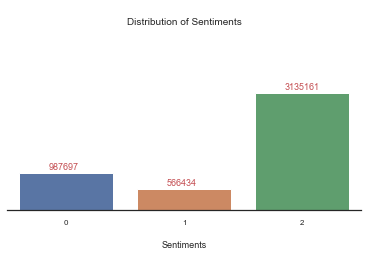

In [5]:
sns.set(style="white")
params = {'axes.spines.top':False, 'axes.spines.right': False, 'axes.spines.left': False, 
          'axes.labelsize' : 9, 'xtick.labelsize' : 8, 'ytick.labelsize' : 8}
matplotlib.rcParams.update(params)
fig = plt.figure(constrained_layout=True, figsize=(5, 2.4))
ax = fig.gca()
sns.countplot(reviews_dataset.sentiment, ax=ax)

counts=reviews_dataset.groupby('sentiment').count().text
for i, txt in enumerate(ax.get_xticklabels()):
    count = counts[int(txt.get_text())]
    ax.text(i-.15, count+100000, '{}'.format(count), fontdict={'fontsize': 9}, c='r')

ax.set_xlabel('\nSentiments')
ax.yaxis.set_visible(False)
fig.suptitle('\nDistribution of Sentiments', y=1.42, fontsize=10);
ax.set_xticklabels(labels=[lbl.get_text().title() for lbl in ax.get_xticklabels()]);

> Having an imbalanced data impacts the model so its important to balance the data that will be used to train the model.

There are 2 ways to approach this:

`1.` Under-sample (reduce) the dataset so that the negative, neutral, and positive sentiments have an equal number of instances.  Since the least number of sentiment is neutral with `570,889` instances, this would mean reducing the dataset from `4,719,873` down to `1,712,667` (`570,889` x 3).  

`2.` Keep the imbalance but assign appropriate class weights during `model.fit` so that the negative and neutral sentiments will be treated equally with the positive sentiments.  This way no data is discarded however the disadvantage of doing this is that a much substantial amount of data will be used for training, approximately `3,303,911` instances (70% of the dataset) which would slow down the training time and as a result may limit the number of epochs for training.

These two options will be tried and result will be observed.

In [81]:
# RandomUnderSampler is used from the imblearn using the sampling-strategy auto
rus = RandomUnderSampler(sampling_strategy='auto')

X = reviews_dataset[['text']]
y = reviews_dataset['sentiment']

X_rus, y_rus = rus.fit_resample(X, y)

# create the new and reduced dataset from under-sampled data
reviews_dataset_new = pd.concat([X_rus, y_rus], axis=1)

# persist the under-sampled data
reviews_dataset_new.to_csv('../yelp_dataset/reviews_dataset_under-sampled.csv', index=False)

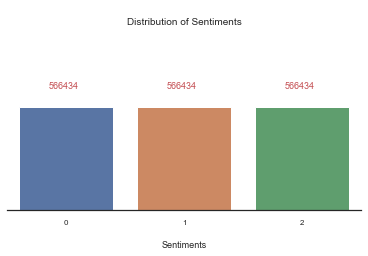

In [82]:
sns.set(style="white")
params = {'axes.spines.top':False, 'axes.spines.right': False, 'axes.spines.left': False, 
          'axes.labelsize' : 9, 'xtick.labelsize' : 8, 'ytick.labelsize' : 8}
matplotlib.rcParams.update(params)
fig = plt.figure(constrained_layout=True, figsize=(5, 2.4))
ax = fig.gca()
sns.countplot(reviews_dataset_new.sentiment, ax=ax)
counts=y_rus.groupby(y_rus).count()
for i, txt in enumerate(ax.get_xticklabels()):
    count = counts[int(txt.get_text())]
    ax.text(i-.15, count+100000, '{}'.format(count), fontdict={'fontsize': 9}, c='r')

ax.set_xlabel('\nSentiments')
ax.yaxis.set_visible(False)
fig.suptitle('\nDistribution of Sentiments', y=1.42, fontsize=10);
ax.set_xticklabels(labels=[lbl.get_text().title() for lbl in ax.get_xticklabels()]);

In [83]:
review_lengths = [len(x[0].split()) for x in X_rus.values]

# plot lenghts of reviews
x=pd.Series(np.array(review_lengths))

# IQR
IQR = x.describe()['75%'] - x.describe()['25%']

# IQR multiplier to set the whisker/boundary for outliers (default is 1.5)
IQR_multiplier = 1.5

# Defining threshold as the 3rd Quartile + (IQR * IQR_multiplier)
outlier_threshold = math.floor(x.describe()['75%'] + (IQR*IQR_multiplier))

print('\nStatistically accepted boundary for outliers : {}\n'.format(outlier_threshold))


Statistically accepted boundary for outliers : 298



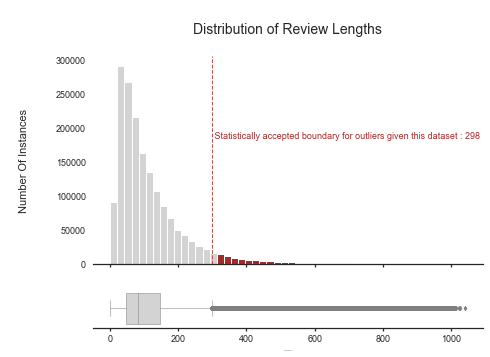

In [84]:
params = {'axes.titlesize':'9', 'xtick.labelsize':'9', 'ytick.labelsize':'9', 'axes.spines.top':False,
          'axes.spines.right': False}
matplotlib.rcParams.update(params)
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .15)})
tmp = ax_hist.set_title('\nDistribution of Review Lengths\n', fontdict={'fontsize': 14});
tmp = ax_hist.set_ylabel('\nNumber Of Instances\n\n', fontdict={'fontsize': 11})
ax_hist.tick_params(bottom="on", length=3)
tmp = ax_hist.axvline(x=outlier_threshold, c='r', linestyle='--', linewidth=1)
text = ' Statistically accepted boundary for outliers given this dataset : {}\n'
tmp = ax_hist.annotate(text.format(int(outlier_threshold)), (outlier_threshold+1, x.count()/10), fontsize=9, color='brown')
ax_box.spines['left'].set_visible(False)
ax_box.tick_params(bottom="on", length=3)
ax_box.yaxis.set_visible(False)

res = x.hist(figsize=(7, 5), color='lightgray', grid=False, ax=ax_hist, bins=50)

for idx, rec in enumerate(res.patches):
    if rec.xy[0] > outlier_threshold-1:
        res.patches[idx].set_fc('brown')  
bx = sns.boxplot(x, ax=ax_box, fliersize=3, color='lightgray', linewidth=.5, whis=IQR_multiplier)
tmp = ax_box.set_xlabel('\nLength of Reviews', fontdict={'fontsize': 1})
#plt.tight_layout();


Does a length of review have any effect on the sentiment?

In [88]:
reviews_dataset_new['length'] = [ len(r.split()) for r in reviews_dataset_new.text ]
reviews_dataset_new.info()
reviews_dataset_new.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699302 entries, 0 to 1699301
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   text       object
 1   sentiment  int64 
 2   length     int64 
dtypes: int64(2), object(1)
memory usage: 38.9+ MB


,text,sentiment,length
0,"My most recent experience with Fairytale brownies has made me decide to find another company to send my sweets out from. An order I placed over the holiday season didn't arrive in the time it was promised, so I canceled the order. Fairytale brownies was OK with the cancellation and stated that my charge card would be credited back the $70 that day in Dec. It is now Jan. 31 and no refund has shown up. When I called to follow up, the woman who looked into it said, oh, the woman you spoke with hasn't been in that's why you haven't been credited. If I hadn't been on top of it, the credit would have never come.",0,118
1,"Our whole family have been regulars for 15 years. We have loved Manuel's in the past. Their prices keep on going up & up. Quality is spotty. I don't think a chef always prepares the meals...especially during slow times for a late lunch. About $15 for 2 ground beef enchilades with rice & beans.Tried their lunch special this week, which was almost $10 for a shredded beef taco and a cheese enchilada. The pork was generous but tasteless and dry. No marinade at all. No sauteed onions. No guacamole. Dry. The cheese enchilada was without any merit. No rice or beans of course, even though they cost restaurants about 25 cents to include. My daughter ordered an a la carte chili relleno, for about $9. No sides. Doesn't resemble a chili relleno. Looked good and tasted good to her. It would be a plus to this part of town if a new management support could make this place consistent, great quality food at more reasonable prices.",0,166
2,First impressions are everything. Ambiance was nice until We were greeted by a hostess who either is not properly trained or truly dislikes her job. I'm leaning towards the latter. The drinks tasted good but overpriced for the small servings. We really liked the guacamole however most of the food was bland. There could be potential with the menu if effort was made to season the food with intent for it to be as flavorful as it was designed to be.,0,81


In [482]:
# create new dataset from the under-sampled dataset
reviews_rus = pd.concat([X_rus, y_rus], axis=1)

# feature engineer length and group from the review text
reviews_rus['length'] = [ len(r.split()) for r in reviews_rus.text ]

# group the lengths by a range
reviews_rus['group'] = reviews_rus['length'].apply(lambda x: math.ceil(x/10))
df_info(reviews_rus)


Shape : (1699302, 4)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  text                           str            False     1699302    1699302
  2.  sentiment                      int64          False     1699302          3
  3.  length                         int64          False     1699302       1007
  4.  group                          int64          False     1699302        104


In [ ]:
neg_series = reviews_rus.query('sentiment == 0').groupby('group').sentiment.count()
neu_series = reviews_rus.query('sentiment == 1').groupby('group').sentiment.count()
pos_series = reviews_rus.query('sentiment == 2').groupby('group').sentiment.count()
combined_series = pd.concat([neg_series, neu_series, pos_series], axis=1)
combined_series.columns = ['negative', 'neutral', 'positive']
combined_series['neg_prop'] = combined_series['negative'] / \
        (combined_series['negative'] + combined_series['neutral']+combined_series['positive'])
combined_series['neu_prop'] = combined_series['neutral'] / \
        (combined_series['negative'] + combined_series['neutral']+combined_series['positive'])
combined_series['pos_prop'] = combined_series['positive'] / \
        (combined_series['negative'] + combined_series['neutral']+combined_series['positive'])

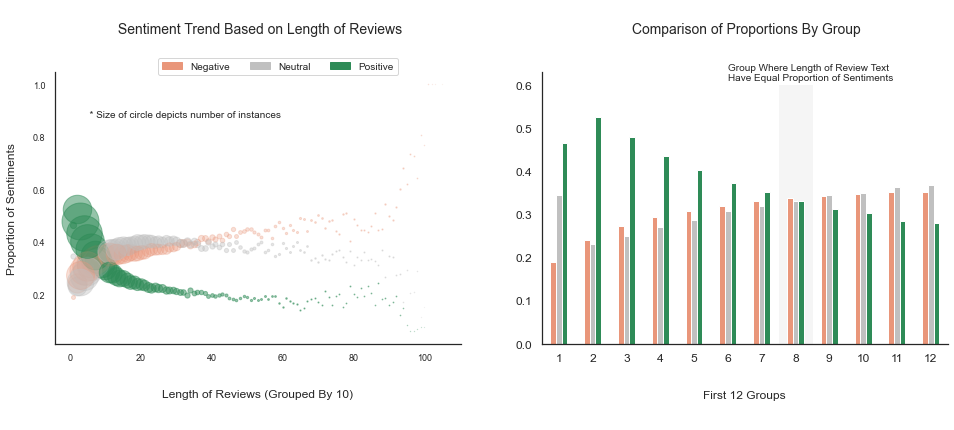

In [687]:
_ = reviews_rus.groupby(['group', 'sentiment']).count()

sns.set_style('white')
params = {'axes.titlesize':'9', 'xtick.labelsize':'9', 'ytick.labelsize':'9', 'axes.spines.top':False,
          'axes.spines.right': False, 'axes.spines.left': True}
matplotlib.rcParams.update(params)

fig = plt.figure(constrained_layout=False, figsize=(16, 5))
ax_scatter = fig.add_subplot(121)
tmp = ax_scatter.set_title('\n Sentiment Trend Based on Length of Reviews\n\n', fontdict={'fontsize': 14});
tmp = ax_scatter.set_ylabel('Proportion of Sentiments\n', fontdict={'fontsize': 12})
tmp = ax_scatter.set_xlabel('\n\nLength of Reviews (Grouped By 10)\n\n', fontdict={'fontsize': 12})
sentiments = [0, 1, 2]
color = {0:'darksalmon', 1:'silver', 2:'seagreen'}
alpha = {0:.3, 1:.4, 2:.5}
label = {0:'Negative', 1:'Neutral', 2:'Positive'}
for group in reviews_rus.group.unique():
    df = _.loc[(group, ), :]
    total = df.text.sum()
    for sentiment in sentiments:
        if not sentiment in df.index:
            continue    
        prop = df.loc[sentiment].text/total
        tmp = ax_scatter.scatter(group, prop, s=df.loc[sentiment].text/12, marker='.', c=color[sentiment], 
                                 alpha=alpha[sentiment]);
patches = []
for s in reviews_rus.sentiment.unique():
    patches.append(mpatches.Patch(color=color[s], label=label[s]))
legend = plt.legend(handles=patches, bbox_to_anchor = (0.55, 1.05), 
                    loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize='10')
tmp = ax_scatter.text(1, .875, '      * Size of circle depicts number of instances', fontsize='10');

ax_bar = fig.add_subplot(122)
combined_series[:12][['neg_prop', 'neu_prop', 'pos_prop']].plot.bar(stacked=False, ax=ax_bar, color=list(color.values()), 
                                                                    rot=0, fontsize=12);
ax_bar.get_legend().remove();
ax_bar.set_xlabel('\n\nFirst 12 Groups', fontdict={'fontsize': 12})
ax_bar.set_title('\n Comparison of Proportions By Group\n\n', fontdict={'fontsize': 14})

ax_bar.fill([6.5, 6.5, 7.5, 7.5], [0, .6, .6, 0], zorder=-1, color='whitesmoke');
ax_bar.text(5, 0.61, 'Group Where Length of Review Text\nHave Equal Proportion of Sentiments', fontsize=10);

> There is a large proportion of positive sentiments for short reviews and the size of the proportion tapers off as length of the review text increases.  
> Conversely, there is small proportion of negative sentiments that increases dramatically as length of the review increases.  
> Most reviews submitted by patrons are relatively short and there are only a small number of people that submit very long reviews and if they do, they are most likely to express a negative sentiment. 